<a href="https://colab.research.google.com/github/lifewinning/MLTSA22_IBurrington/blob/main/HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and loading data

In [327]:
import numpy as np
import pylab as pl

from sklearn import model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import skew

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras import optimizers

In [2]:
pl.style.use('seaborn')
import pandas as pd

In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
cd /content/gdrive/MyDrive/MLTSA22/PLAsTiCC2018/

/content/gdrive/MyDrive/MLTSA22/PLAsTiCC2018


In [5]:
ls

garbage.npy      lcvs.npy     model.png         training_set.csv.zip
garbage_std.npy  lcvs_pb.npy  training_set.csv  training_set_metadata.csv


Realized partway through this homework that it might be helpful to start from standardized data, so re-did that but of HW8. 

In [6]:
lcvs_np_s = np.load('garbage_std.npy').reshape(7848, 6, 100)

In [7]:
indices = np.arange(0, len(lcvs_np_s))
X_train, X_test, index_train, index_test = model_selection.train_test_split(lcvs_np_s, indices, test_size=0.2, random_state=12)

In [8]:
X_train.shape

(6278, 6, 100)

# Comparing autoencoder models

I'm not including all the variations I tried before because if you try to run it colab will break, but here's an explanation of why I made the choices I made in my model

**Layer units**: honestly these were kind of a guess--I'm just assuming that there's some good bit-based reason most examples of autoencoders use powers of 2. 

**Activation functions**: I landed on the activation functions here after realizing that most of the activation functions we saw in the example notebooks were based on reducing outputs to 0 and 1 or have a minimum value of 0--which isn't very helpful in a dataset with negative numbers. A linear activation function probably would have been fine, but the loss function results didn't show much of a curve (wait, can...can we call that a "learning curve"?) so suspected it would take a long long time to actually converge, and elu seemed to be more effective. I chose tanh for my compression and bottleneck because I wanted to retain a negative number space--it seemed like it was harder to re-create negative values when expanding the data from sigmoid or relu. 

**Optimizer**: adadelta created a smoother learning curve, but adam produced a lower mean squared error--it would probably be safer to go with adadelta, but I'm showing both just to compare. 

**Epochs**: I probably could have run the adadelta-optmized model longer to get even closer to 0 but I didn't want to get rate-limited by Colab, and it might have even made sense to run the Adam-optimized model for less time to prevent possible overfitting, but I think it's basically good enough?

In [9]:
ndim = X_train[0].shape[1]
model_lcvs_ada = Sequential()

model_lcvs_ada.add(Dense(128, activation='elu', input_dim=ndim, input_shape=(6,100)))
model_lcvs_ada.add(Dense(64, activation='tanh'))

#bottleneck
model_lcvs_ada.add(Dense(32, activation='tanh'))

model_lcvs_ada.add(Dense(64, activation='tanh'))
model_lcvs_ada.add(Dense(128, activation='elu'))
#output layer, same size as input
model_lcvs_ada.add(Dense(ndim, activation='elu'))


In [10]:
model_lcvs_ada.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6, 128)            12928     
                                                                 
 dense_1 (Dense)             (None, 6, 64)             8256      
                                                                 
 dense_2 (Dense)             (None, 6, 32)             2080      
                                                                 
 dense_3 (Dense)             (None, 6, 64)             2112      
                                                                 
 dense_4 (Dense)             (None, 6, 128)            8320      
                                                                 
 dense_5 (Dense)             (None, 6, 100)            12900     
                                                                 
Total params: 46,596
Trainable params: 46,596
Non-traina

In [11]:
model_lcvs_ada.compile(optimizer="adadelta", 
                    loss="mean_squared_error")
history_ada = model_lcvs_ada.fit(X_train, X_train, 
                               validation_data=(X_test, X_test),
                               epochs=500, batch_size=50, verbose=1)

Epoch 1/500
126/126 [==============================] - 2s 9ms/step - loss: 0.8268 - val_loss: 0.8205
Epoch 2/500
126/126 [==============================] - 1s 6ms/step - loss: 0.8204 - val_loss: 0.8141
Epoch 3/500
126/126 [==============================] - 1s 7ms/step - loss: 0.8138 - val_loss: 0.8075
Epoch 4/500
126/126 [==============================] - 1s 7ms/step - loss: 0.8071 - val_loss: 0.8009
Epoch 5/500
126/126 [==============================] - 1s 7ms/step - loss: 0.8004 - val_loss: 0.7943
Epoch 6/500
126/126 [==============================] - 1s 7ms/step - loss: 0.7937 - val_loss: 0.7877
Epoch 7/500
126/126 [==============================] - 1s 6ms/step - loss: 0.7871 - val_loss: 0.7812
Epoch 8/500
126/126 [==============================] - 1s 6ms/step - loss: 0.7805 - val_loss: 0.7748
Epoch 9/500
126/126 [==============================] - 1s 6ms/step - loss: 0.7741 - val_loss: 0.7684
Epoch 10/500
126/126 [==============================] - 1s 7ms/step - loss: 0.7677 - val_lo

In [12]:
model_lcvs_adam = Sequential()

model_lcvs_adam.add(Dense(128, activation='elu', input_shape=(6, 100)))
model_lcvs_adam.add(Dense(64, activation='tanh'))

#bottleneck
model_lcvs_adam.add(Dense(32, activation='tanh'))

model_lcvs_adam.add(Dense(64, activation='tanh'))
model_lcvs_adam.add(Dense(128, activation='elu'))
#output layer, same size as input
model_lcvs_adam.add(Dense(ndim, activation='elu'))


In [13]:
model_lcvs_adam.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6, 128)            12928     
                                                                 
 dense_7 (Dense)             (None, 6, 64)             8256      
                                                                 
 dense_8 (Dense)             (None, 6, 32)             2080      
                                                                 
 dense_9 (Dense)             (None, 6, 64)             2112      
                                                                 
 dense_10 (Dense)            (None, 6, 128)            8320      
                                                                 
 dense_11 (Dense)            (None, 6, 100)            12900     
                                                                 
Total params: 46,596
Trainable params: 46,596
Non-trai

In [14]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model_lcvs_adam.compile(optimizer=opt, 
                    loss="mean_squared_error")

In [15]:
history_adam = model_lcvs_adam.fit(X_train, X_train, 
                               validation_data=(X_test, X_test),
                               epochs=50, batch_size=100, verbose=1)

Epoch 1/50
63/63 [==============================] - 2s 15ms/step - loss: 0.2176 - val_loss: 0.1241
Epoch 2/50
63/63 [==============================] - 1s 13ms/step - loss: 0.1060 - val_loss: 0.0914
Epoch 3/50
63/63 [==============================] - 1s 13ms/step - loss: 0.0849 - val_loss: 0.0823
Epoch 4/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0789 - val_loss: 0.0849
Epoch 5/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0735 - val_loss: 0.0720
Epoch 6/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0723 - val_loss: 0.0678
Epoch 7/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0692 - val_loss: 0.0690
Epoch 8/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0695 - val_loss: 0.0697
Epoch 9/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0686 - val_loss: 0.0652
Epoch 10/50
63/63 [==============================] - 1s 11ms/step - loss: 0.0697 - val_loss: 0.0723
Epoch 11/

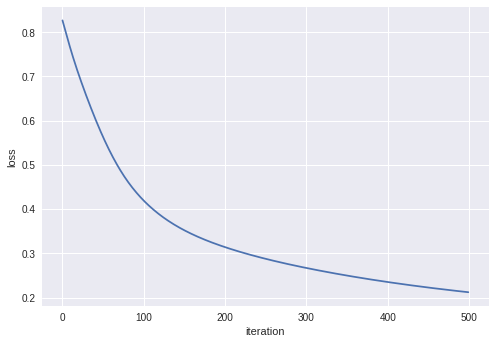

In [16]:
pl.plot(np.array(history_ada.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration');

Fig. 1: Loss plot of model using adadelta optimization. It probably could use some more training but I'm worried about getting rate limited by Colab. 

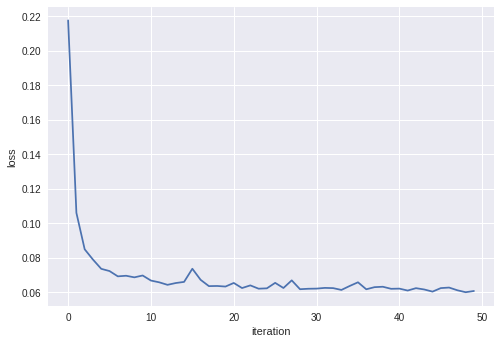

In [17]:
pl.plot(np.array(history_adam.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration');

Fig. 2: Loss plot for autoencoder model using Adam optimizer. This isn't great, and there's some overfitting risk maybe? 

In [18]:
model_output_adam = model_lcvs_adam.predict(X_test)
model_output_ada = model_lcvs_ada.predict(X_test)

In [19]:
np.random.seed(123)
targets = X_test.shape[0]
choices = np.random.choice(targets, 10, replace = False)

In [20]:
choices

array([ 221, 1171, 1386, 1407,  591,  700,   31,  276, 1229, 1419])

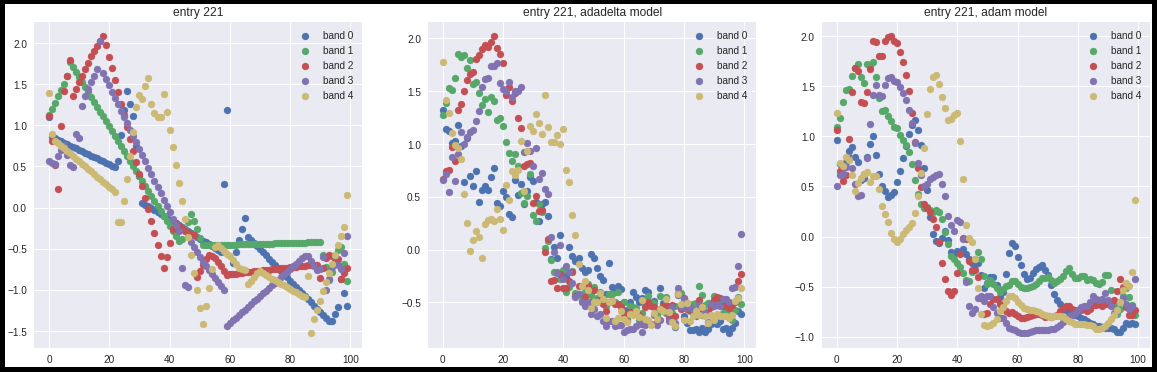

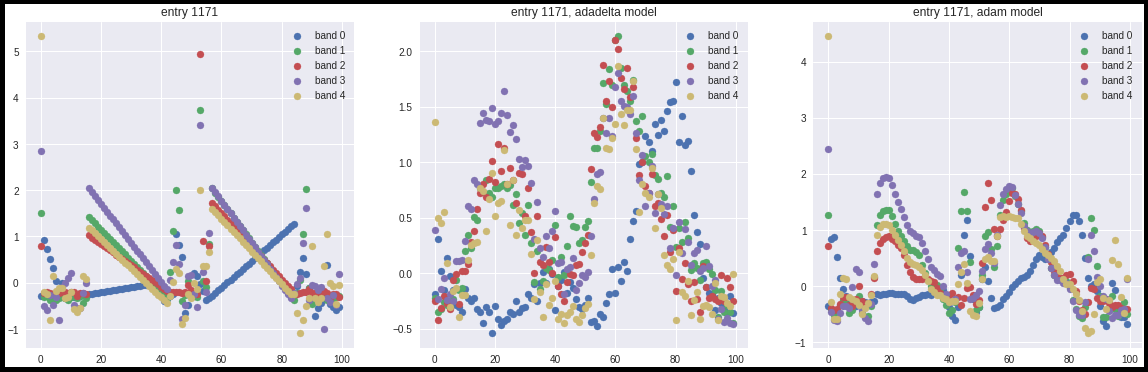

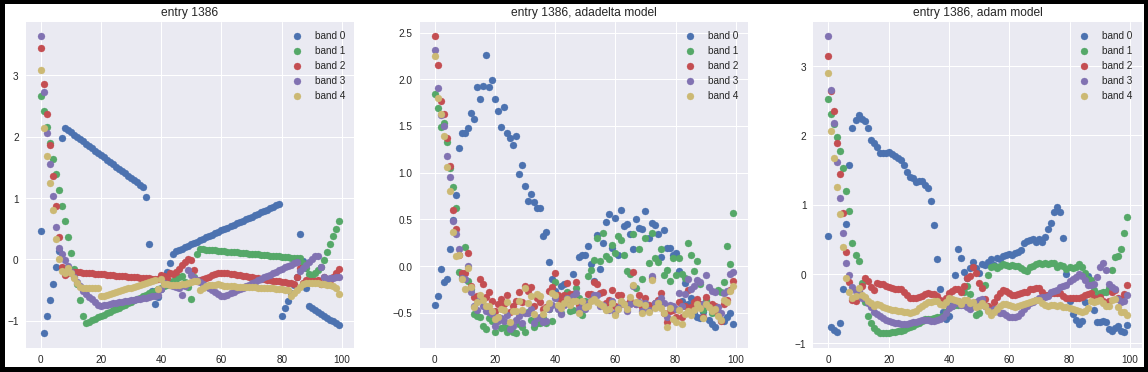

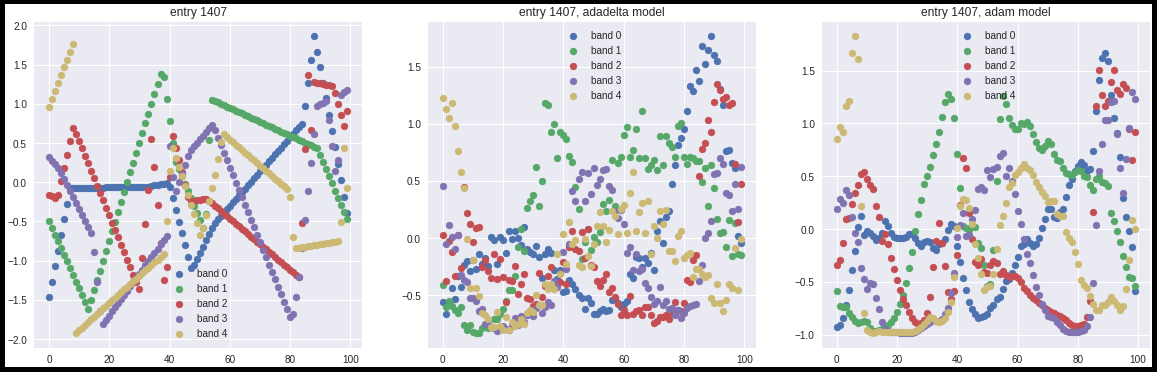

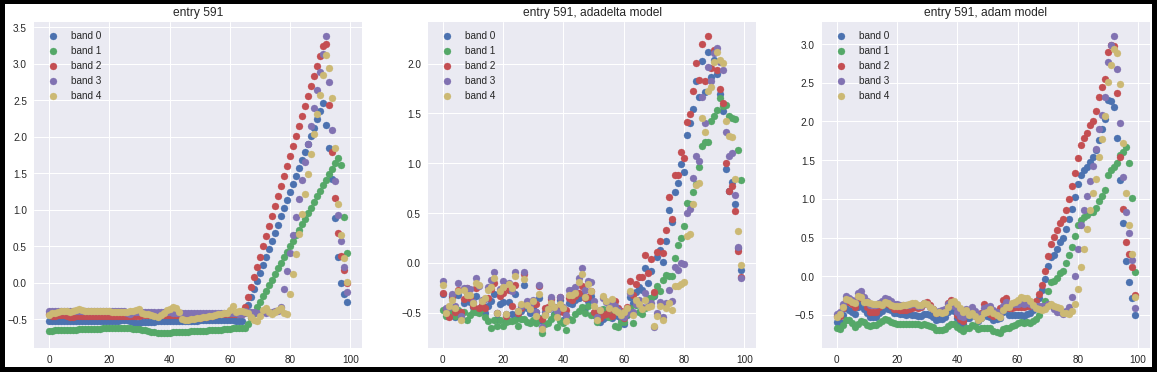

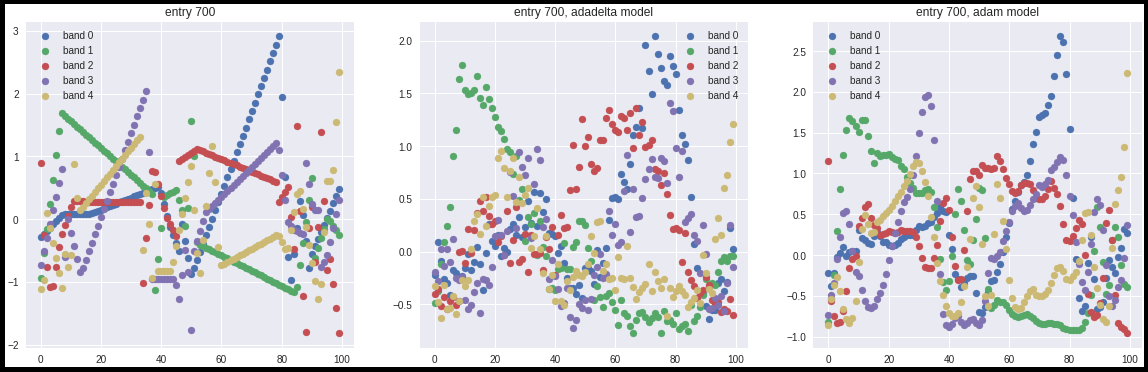

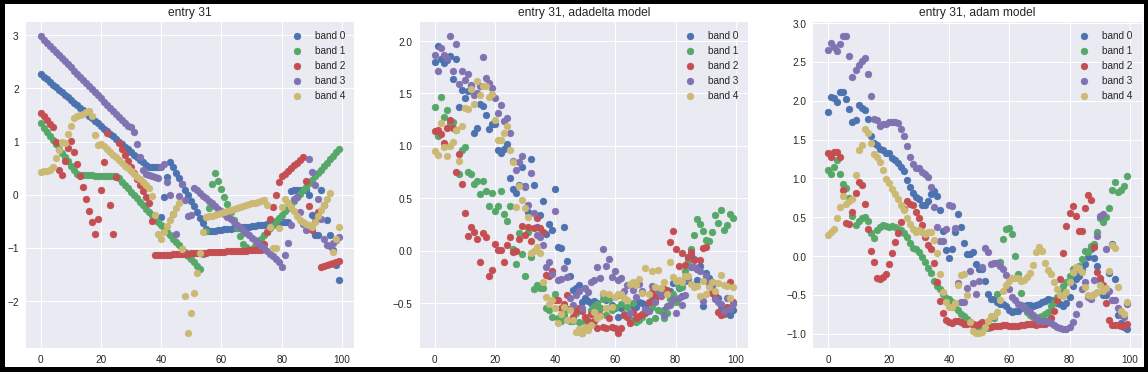

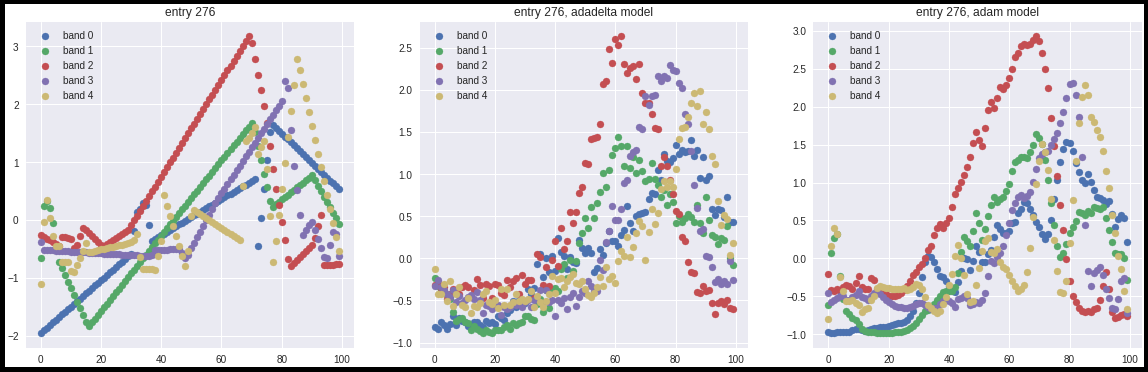

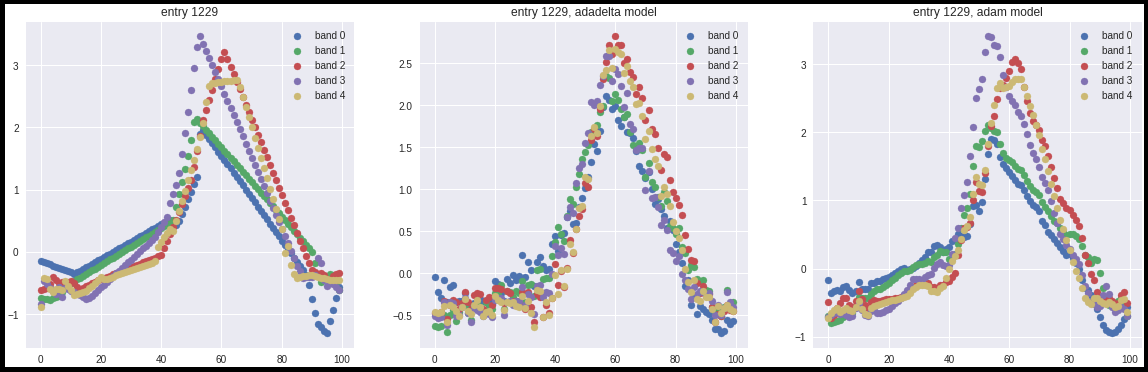

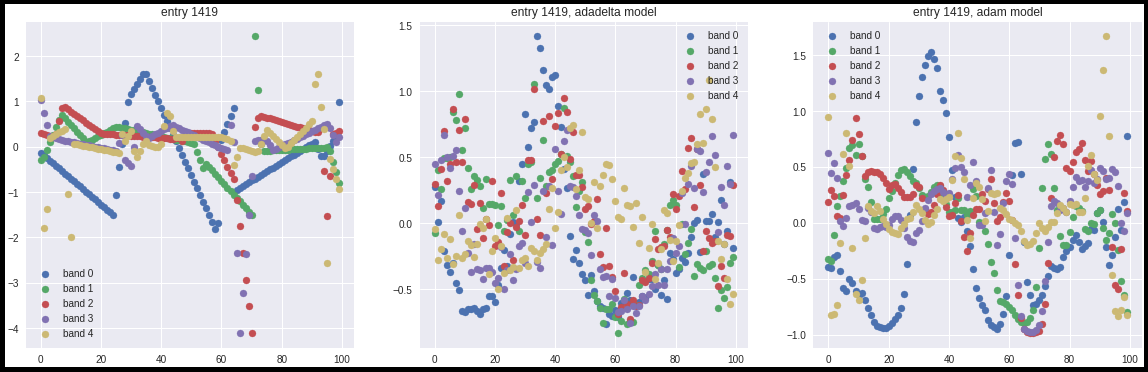

In [21]:
# comparing test results to original lightcurve
for choice in choices: 

  fig, ax = pl.subplots(1, 3, figsize=(20, 6),linewidth=10, edgecolor="black")
  for band in np.arange(0,5):
    ax[0].set_title("entry {0}".format(choice))
    ax[1].set_title("entry {0}, adadelta model".format(choice))
    ax[2].set_title("entry {0}, adam model".format(choice))
    ax[0].scatter(np.arange(0,100), X_test[choice][band], label ="band {0}".format(band))
    ax[1].scatter(np.arange(0,100), model_output_ada[choice][band], label="band {0}".format(band))
    ax[2].scatter(np.arange(0,100), model_output_adam[choice][band], label="band {0}".format(band))
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()


Fig. 3: comparing outputs of test data and model predictions on 10 randomly selected items in the test set. The Adam-optimized model only looks slightly better? But hard to say for sure just from this handful of plots. 

In [22]:
def mse_arr(a, b):
  return ((a-b)**2).mean(axis=1)

In [23]:
mse_arr(X_test, model_output_ada)

array([[0.48372904, 0.26646785, 0.13670096, ..., 0.10399592, 0.07650672,
        0.15548794],
       [0.2983011 , 0.38707182, 0.81783767, ..., 0.16529854, 0.27079275,
        0.17341372],
       [0.28062639, 0.2596892 , 0.14613135, ..., 0.11757877, 0.21491382,
        0.94103779],
       ...,
       [0.1919504 , 0.05187228, 0.07874805, ..., 0.23397059, 0.09361263,
        0.12337673],
       [0.16486701, 0.06184246, 0.03949287, ..., 0.11121814, 0.29595144,
        0.2195085 ],
       [0.33226313, 0.22535567, 0.10757327, ..., 0.10440404, 0.0448634 ,
        0.03229901]])

In [24]:
print("total mse of adadelta model: {}".format(mse_arr(X_test, model_output_ada).mean()))
print("total mse of adam model: {}".format(mse_arr(X_test, model_output_adam).mean()))


total mse of adadelta model: 0.2132473181885135
total mse of adam model: 0.06440205782483148


In [25]:
mse_ada = [mse_arr(X_test[choice], model_output_ada[choice]) for choice in np.arange(0,len(X_test))]
mse_adam = [mse_arr(X_test[choice], model_output_adam[choice]) for choice in np.arange(0,len(X_test))]

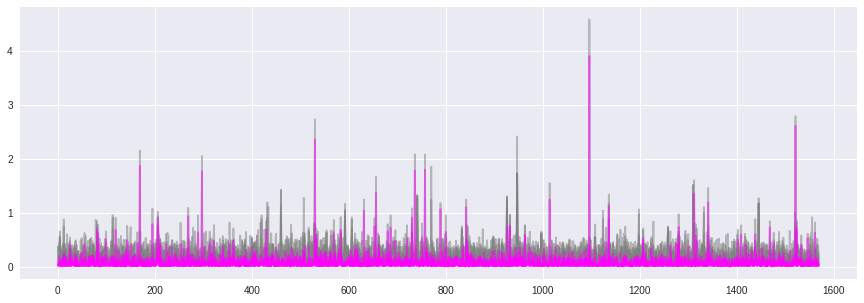

In [26]:
fig, ax = pl.subplots(figsize=(15, 5))
pl.plot(np.arange(0,len(X_test)), mse_ada, label="MSE, ada predictions", color="gray", alpha=0.5)
pl.plot(np.arange(0,len(X_test)), mse_adam, label="MSE, adam predictions", color="magenta", alpha=0.5);
# pl.legend();

Fig. 4: Comparing the mean squared errors of my two models--the adadelta-optimized model is generally higher. Again, running it a little longer might have made a difference. Even where the Adam-optimized model spikes, it's still smaller values than the adadelta model.

# What I learned

Overall, I'm pretty impressed with the autoencoder's accuracy, but I don't really know if it tells me very much about the PLAsTiCC data because the interpolation and structuring of my data feels like such an abstraction from the original dataset. 

# Looking at our bottleneck layer

In [27]:
# input placeholder
inp = model_lcvs_adam.input                   
# extract the bottle neck outputs
outputs = model_lcvs_adam.layers[2].output     
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])    

# Testing
layer_outs = functors(X_test)
layer_outs[0][0]

array([[ 0.1105998 ,  0.27620035, -0.42789033,  0.13791266,  0.07466329,
        -0.17209865, -0.09442463, -0.10903185, -0.15144844, -0.06263503,
        -0.29852927, -0.07800288,  0.35099417, -0.37935644,  0.03349635,
         0.16706756,  0.3046523 ,  0.02041266, -0.09537197,  0.14087188,
         0.3192365 , -0.28642946, -0.04100199,  0.11351565,  0.33514455,
         0.3445332 , -0.23732106, -0.2829648 ,  0.06590351,  0.01935573,
         0.17387575,  0.18001999],
       [-0.26300064,  0.04939524,  0.03317444,  0.32387266, -0.14870013,
         0.17395307, -0.02961852,  0.36008042,  0.06534286,  0.04679341,
         0.18998814,  0.12795939, -0.14918809,  0.18076614, -0.1950904 ,
         0.3697771 ,  0.08653904,  0.2019887 ,  0.22784533, -0.15026872,
         0.10741791,  0.1808621 ,  0.13099377, -0.06739838, -0.02126169,
        -0.11784377,  0.11259395, -0.3354925 , -0.13091725,  0.10276636,
         0.1220732 ,  0.0516957 ],
       [ 0.22608317, -0.14460953, -0.0356018 , -0.0130

In [28]:
layer_outs[0][0].shape

(6, 32)

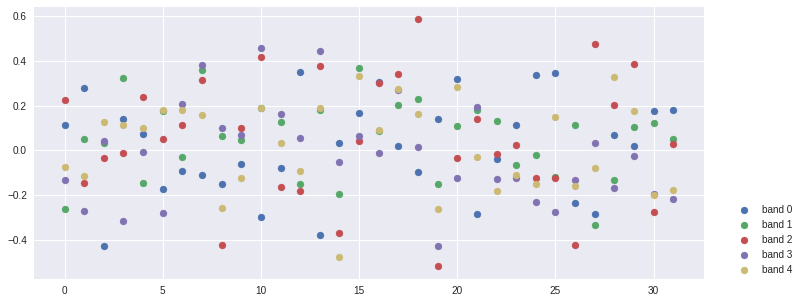

In [29]:
fig, ax = pl.subplots(figsize=(12, 5))
for item in np.arange(0, 5): 
  ax.scatter(np.arange(0,32), layer_outs[0][0][item], label='band {0}'.format(item))
  ax.legend(loc=(1.04,0))

Fig. 5: bottleneck layer results of model predictions on the first object interpolation from the test data. Mostly I just wanted to see them all together to get a sense of whether/how much they differ from each other. Apparently, not by very much! 

# Random forest

## Importing training set and metadata, feature extraction (original data)

In [30]:
# I realize calling this "raw" data is problematic aside from the fact raw data is a fiction but I didn't feel creative
lcvs_raw = pd.read_csv('training_set.csv')

In [31]:
# just a reminder of what we are looking at
lcvs_raw.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [150]:
metadata = pd.read_csv('training_set_metadata.csv')
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [33]:
# my silly little functions for doing my silly little merges

def features_df_agg(df, lam, name):
  newdf = df.groupby(["object_id", "passband"])[["flux"]].agg(lam)
  newdf.rename(columns={'flux': name}, inplace=True)
  return newdf

def features_df_app(df, lam, name):
  newdf = df.groupby(["object_id", "passband"])[["flux"]].apply(lam)
  newdf.rename(columns={'flux': name}, inplace=True)
  return newdf
  
# function for merging
def mergeon(df1, df2): 
  return df1.merge(df2, left_index=True, right_index=True)

In [34]:
lcvs_raw['flux_s'] = features_df_app(lcvs_raw, (lambda x: (x - x.mean()) - x.std()), 'std_flux').values

In [35]:
s_median = lcvs_raw.groupby(["object_id", "passband"])[["flux_s"]].median()
s_median.rename(columns={'flux_s': 's_median'}, inplace=True)

In [36]:
# get min and max with error, raw data--probably could have done this with features_df but wasn't sure how to do the error merge

min = lcvs_raw.groupby(["object_id", "passband"])[["flux"]].min().reset_index()

# on the off chance any max values are duplicates, also match by id
merge = pd.merge(min,lcvs_raw[['flux','flux_err','object_id']],on=['flux', "object_id"])
merge.rename(columns={"flux": "min", 'flux_err': 'min_err'}, inplace=True)
merge = merge.groupby(["object_id", "passband"]).min()

max = lcvs_raw.groupby(["object_id", "passband"])[["flux"]].max().reset_index()

merge2 = pd.merge(max,lcvs_raw[['flux','flux_err','object_id']],on=['flux', "object_id"])
merge2.rename(columns={"flux": "max", 'flux_err': 'max_err'}, inplace=True)
merge2 = merge2.groupby(["object_id", "passband"]).max()

features = mergeon(merge, merge2)

In [37]:
features = mergeon(features, s_median)

In [38]:
extracts  = [
    features_df_agg(lcvs_raw, (lambda x: x.std()), "std"), # standard deviation 
    features_df_agg(lcvs_raw, (lambda x: x.mean()), "mean"), # mean 
    features_df_app(lcvs_raw, (lambda x: x.skew()), "skew"), # skew
]

for ext in extracts: 
  features = mergeon(features, ext)

features

min    min_err           max     max_err  \
object_id passband                                                     
615       0         -116.913223   3.097836    125.182808    3.909554   
          1        -1100.440063   6.709106    660.626343    4.961018   
          2         -681.858887   4.041204    611.984558    3.908728   
          3         -530.644592   3.672556    445.737061    3.952905   
          4         -422.184509   4.089213    381.953735    3.885009   
...                         ...        ...           ...         ...   
130779836 1          -34.273514  19.637548   3320.936279   56.901775   
          2          -14.478923  23.485855  31437.089844  362.050262   
          3          -41.850040  26.782366   4995.144043   50.181072   
          4          -72.634567  44.931393  54982.875000  424.749237   
          5          -86.457382  57.588879  29058.212891  210.280746   

                        s_median           std         mean      skew  
object_id passband                                                     
615       0           -90.705405     83.944735    -3.254554  0.128917  
          1          -704.145359    601.787302  -385.699911  0.415580  
          2          -586.660785    455.121346  -134.146566  0.339918  
          3          -376.492496    335.425053  -121.103501  0.293128  
          4          -339.390223    291.803449   -55.954592  0.200096  
...                          ...           ...          ...       ...  
130779836 1         -1813.068527   1197.557111   725.169852  1.798901  
          2         -8731.842799   6440.422386  2690.360415  4.057211  
          3         -2030.515105   1443.868085   755.993902  2.554678  
          4        -14411.352211  11006.766106  3489.185336  4.484138  
          5        -12306.688396   8687.101173  4151.358875  2.463557  

[47088 rows x 8 columns]

In [41]:
metadata_reset = metadata.set_index('object_id')
cols = ['decl','ra', 'hostgal_specz']

merge_metadata = metadata_reset[cols]

final_features = mergeon(features.unstack(1), merge_metadata)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


In [40]:
final_features

,"(min, 0)","(min, 1)","(min, 2)","(min, 3)","(min, 4)","(min, 5)","(min_err, 0)","(min_err, 1)","(min_err, 2)","(min_err, 3)",...,"(skew, 0)","(skew, 1)","(skew, 2)","(skew, 3)","(skew, 4)","(skew, 5)",decl,ra,hostgal_specz,target
object_id,,,,,,,,,,,,,,,,,,,,,
615,-116.913223,-1100.440063,-681.858887,-530.644592,-422.184509,-422.815094,3.097836,6.709106,4.041204,3.672556,...,0.128917,0.415580,0.339918,0.293128,0.200096,0.125268,-61.943836,349.046051,0.0000,92
713,-14.735178,-11.715749,-10.067919,-12.394593,-12.286801,-14.211164,2.326417,0.823976,0.717739,1.305202,...,0.260052,-0.087865,-0.022678,-0.167176,-0.064134,0.218182,-27.784405,53.085938,1.8181,88
730,-3.459960,-3.393080,-2.848838,-5.435799,-5.836310,-19.159811,2.511074,3.564052,1.924783,2.359130,...,0.356910,0.471342,2.385066,2.662075,2.537802,1.680352,-6.579593,33.574219,0.2320,42
745,-3.874349,-3.618410,-2.159753,-4.944036,-15.494463,-10.249387,1.722069,1.775791,0.886318,1.682349,...,2.023211,7.007099,5.688194,3.751603,3.476420,3.170857,-45.586655,0.189873,0.3037,90
1124,-6.804703,-2.622109,-2.084535,-2.800270,-16.543753,-10.860540,3.029140,2.528914,1.200008,1.923729,...,-0.332169,2.377222,3.075437,3.603208,3.904008,3.657305,-63.823658,352.711273,0.1934,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130739978,-23.468113,-3.726851,-7.384562,-10.646696,-35.209919,-105.375282,6.657956,1.700991,4.707164,9.599122,...,1.784807,3.680811,2.753125,0.410709,0.431793,3.998852,-14.940303,26.718750,0.0000,65
130755807,-22.168346,-2.173342,-9.390373,-31.347395,-43.322540,-69.036392,24.077696,3.185611,8.236696,13.690124,...,3.192929,2.970945,0.014138,3.576847,2.493254,1.133398,-62.696659,120.101349,0.1725,90
130762946,-135.602631,-90.300354,-80.965820,-69.581696,-49.501961,-87.510719,76.816002,19.868319,13.244308,13.686595,...,-2.131699,-1.754200,-0.076740,0.313884,0.608803,1.533518,-55.682144,203.108109,0.0000,16


# I feel like I am throwing spaghetti at a wall but let's see how this goes

## Random forest on original data

One of the skew results producces a NaN--I'm dropping it because I think there's enough data to work with here?

In [58]:
final_features[final_features[('skew', 0)].isna()].index

Int64Index([74256178], dtype='int64', name='object_id')

In [60]:
final_features.drop(labels=74256178, axis=0, inplace=True)

In [148]:
meta_rf = metadata.drop(labels = metadata[metadata['object_id'] ==74256178].index, axis = 0)

In [149]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(final_features, meta_rf['target'], test_size=0.2, random_state=12)

In [65]:
forest = RandomForestClassifier(max_depth=5)

In [66]:
forest.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


RandomForestClassifier(max_depth=5)

In [71]:
y_pred_test = forest.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


In [105]:
accuracy_score(y_test, y_pred_test)

0.6312101910828025

This classifier is only slightly better than a coin toss. 

In [123]:
matrix = confusion_matrix(y_test, y_pred_test)

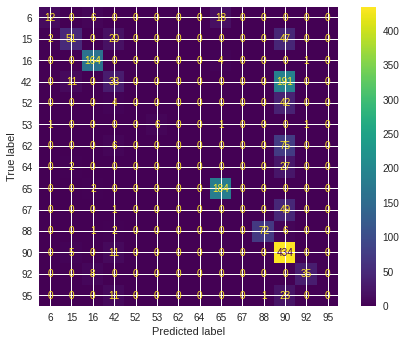

In [130]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=forest.classes_)
disp.plot()

Fig. 6: Confusion matrix for my random forest classifier using original data. It's pretty good at identifying class 90 objects, but class 42 objects are also sometimes misinterpreted as class 90 objects. The rest of the objects are pretty bad.

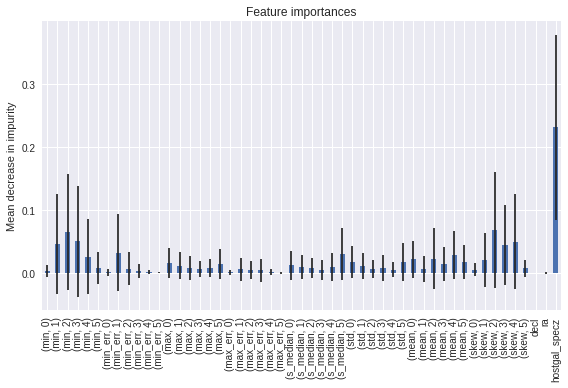

In [137]:
importances =forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=final_features.columns)

fig, ax = pl.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Fig. 7: Feature importance bar chart for my random forest. I might have expected location to be more important than redshift? I'm curious about the fact different bands have different levels of importance. 

# Feature extraction, autoencoder bottleneck

So the indices of my interpolated data should match the indices of my metadata entries because the interpolated data was the result of a groupby, which puts the data in ascending order. I'm not including min and max in this version because with the data now standardized I'm not sure it's especially informative and in my original random forest it wasn't that effective. 

In [138]:
layer_outs[0].shape

(1570, 6, 32)

In [314]:
bottleneck_df = pd.DataFrame(data = None, columns=['object_id','ra','decl','hostgal_specz'])

In [315]:
for band in np.arange(0,6):
  bottleneck_df['mean_{0}'.format(band)] = 0

for band in np.arange(0,6):
  bottleneck_df['median_{0}'.format(band)] = 0

for band in np.arange(0,6):
  bottleneck_df['skew_{0}'.format(band)] = 0

In [317]:
s_means = ([[j.mean() for j in i] for i in layer_outs[0]])
s_medians = ([[np.median(j) for j in i] for i in layer_outs[0]])
skew = ([[skew(j) for j in i] for i in layer_outs[0]])

In [318]:
for index, layer in enumerate(layer_outs[0]):
  hostgal, target, id = 0,0,0
  for ind, item in enumerate(index_test): 
      if index == ind:
        id  = metadata.iloc[item]['object_id']
        decl = metadata.iloc[item]['decl']
        ra = metadata.iloc[item]['ra']
        hostgal = metadata.iloc[item]['hostgal_specz']
        bottleneck_df.loc[len(bottleneck_df.index)] = [id, decl, ra, hostgal] + s_means[index] + s_medians[index] + skew[index]
    


In [319]:
index_test

array([7221, 4041, 4223, ..., 2721, 6896, 2973])

In [322]:
metadata.iloc[7221]['object_id']

116764335.0

In [320]:
bottleneck_df

,object_id,ra,decl,hostgal_specz,mean_0,mean_1,mean_2,mean_3,mean_4,mean_5,...,median_2,median_3,median_4,median_5,skew_0,skew_1,skew_2,skew_3,skew_4,skew_5
0,116764335.0,-27.953188,22.675781,0.2143,0.014123,0.051159,0.046686,-0.020108,0.017172,0.036143,...,0.034147,-0.019272,0.061976,0.061702,-0.204250,-0.245747,-0.148445,0.460002,-0.333972,-0.516876
1,44088638.0,-0.298417,39.902344,0.3091,0.044269,-0.043577,-0.011071,-0.047825,-0.007828,0.011859,...,-0.045134,-0.047271,-0.012088,-0.003992,0.190382,0.437342,0.200585,-0.157486,0.372498,0.152737
2,48392399.0,-34.228867,89.824219,0.3215,-0.066299,0.031436,-0.034516,-0.037845,-0.032668,-0.008959,...,-0.017652,-0.067314,-0.046005,-0.048605,0.152521,0.286449,0.029703,-0.054520,0.313872,0.327732
3,82592591.0,-24.460293,336.445312,0.3704,-0.049982,-0.035416,-0.038298,-0.044605,-0.032652,-0.043115,...,-0.067547,-0.093418,-0.019629,-0.046997,0.159114,-0.018775,0.256138,0.112233,-0.107683,-0.338649
4,289969.0,-62.508568,347.617462,0.1287,0.023231,-0.005189,-0.004054,-0.005753,-0.007579,-0.005291,...,-0.077688,-0.060762,-0.011181,-0.054817,-0.237089,0.080266,0.082957,0.075787,0.067227,0.083754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1565,64264583.0,-16.334824,165.058594,0.0000,-0.055281,0.017011,-0.027129,-0.013597,-0.014884,0.000684,...,-0.072963,-0.046288,-0.045137,-0.040827,-0.503370,0.575099,0.284080,0.239164,0.150995,0.095710
1566,90399.0,-27.784405,51.328125,0.0000,0.084450,-0.005531,-0.006942,-0.011995,-0.015328,-0.001469,...,-0.031454,-0.010322,0.004715,0.033891,-0.415915,0.568536,0.234059,0.718106,-0.097334,-0.419371
1567,14361367.0,-2.388015,114.433594,0.5142,-0.011384,0.025205,0.000870,0.055519,0.013390,-0.068377,...,-0.050206,0.056626,0.022851,-0.071786,-0.360772,-0.144726,0.193444,-0.042537,0.100166,0.434983
1568,109431067.0,-32.974850,234.140625,0.2979,0.001695,-0.016162,-0.045712,-0.048509,-0.041339,-0.037325,...,-0.015071,-0.048164,-0.059412,-0.093251,0.038574,0.022082,-0.322084,-0.184320,0.523789,0.546695


In [324]:
targets = []
for index, layer in enumerate(layer_outs[0]):
  hostgal, target, id = 0,0,0
  for ind, item in enumerate(index_test): 
      if index == ind:
        target = metadata.iloc[item]['target']
        targets.append(target)

In [333]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(bottleneck_df, targets, test_size=0.2, random_state=12)

In [334]:
forest32 = RandomForestClassifier(max_depth=5)
forest32.fit(x_train, y_train)

RandomForestClassifier(max_depth=5)

In [335]:
y_pred_test = forest32.predict(x_test)

In [336]:
accuracy_score(y_test, y_pred_test)

0.4681528662420382

Yikes, my classifier got worse!

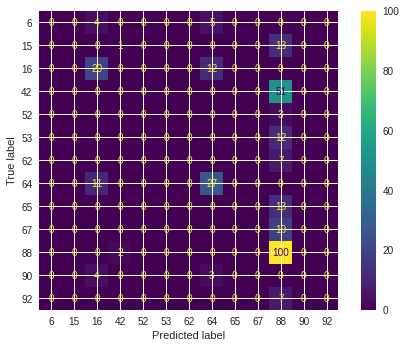

In [337]:
matrix = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=forest.classes_)
disp.plot();

Fig. 8: Confusion matrix for random forest classifier using compression layer from my autoencoder. Apparently it did a great job on exactly one label (88), but I don't know how many items in my test set were labeled 88. In general though, it's pretty bad. 

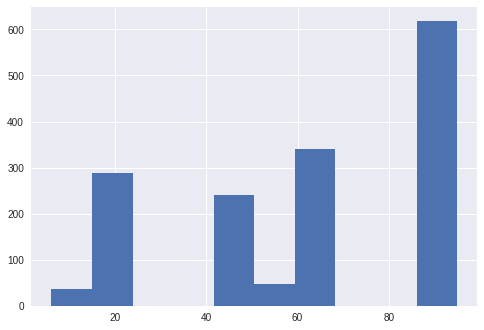

In [342]:
pl.hist(targets);

Fig. 9: Histogram of target labels in my test data. Label 88 is pretty well-represented, so maybe the classifier got really good at identifying that one because it had more examples to learn on? 

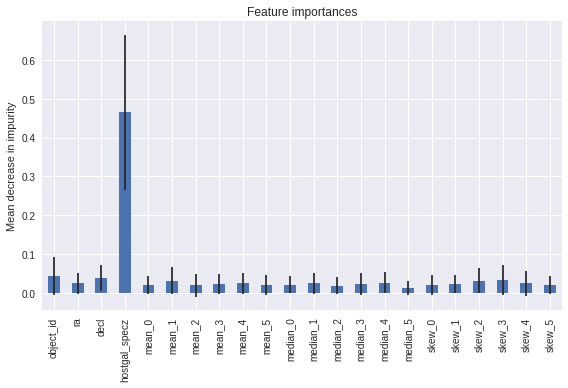

In [344]:
importances =forest32.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest32.estimators_], axis=0)

forest_importances = pd.Series(importances, index=bottleneck_df.columns)

fig, ax = pl.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Fig. 10: Bar chart of feature importance for my bottleneck-data random forest. Once again, redshift seems to win the day. My main takeaway from this is that I probably should have tried some other features for this like getting linear regressions for my passbands. Maybe standardizing for the autoencoder was a mistake? 